In [3]:
# 必要なライブラリのインストール
!pip install librosa matplotlib

import librosa # f0を読み込むためのライブラリ
import numpy as np # 配列操作用。機械学習においては[n, 1]という配列を用いるため、npを用いて配列操作するのが利にかなっている
import matplotlib.pyplot as plt # データ可視化ライブラリの一つ。著感的なコマンドでグラフ（折れ線、散布図、棒グラフ等）を作成可能
from IPython.display import Audio, display # UIを綺麗にしてdisplayするためのライブラリ。audioを出力する際に用いる
from google.colab import output # よくわからないライブラリ
from base64 import b64decode # Base64形式で保存されたデータを元のバイナリ形式に戻すためのもの

# 録音用のJavascriptコード（Colab特有のおまじない）
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time * 1000)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  print("🔴 録音開始... (5秒間歌ってください)")
  output.eval_js(RECORD)
  text = output.eval_js('record(%d)' % (sec))
  name = 'my_voice.wav'
  with open(name, 'wb') as f:
    f.write(b64decode(text.split(',')[1]))
  print("✅ 録音完了: my_voice.wav")
  return name

# 実行して録音する
filename = record(sec=5)

# 録音した音を読み込む
# y: 音声データ, sr: サンプリングレート
y, sr = librosa.load(filename, sr=16000)

# 確認のため再生
print("元の音声:")
display(Audio(y, rate=sr))

🔴 録音開始... (5秒間歌ってください)
✅ 録音完了: my_voice.wav


/tmp/ipython-input-3145970240.py:50: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=16000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


元の音声:


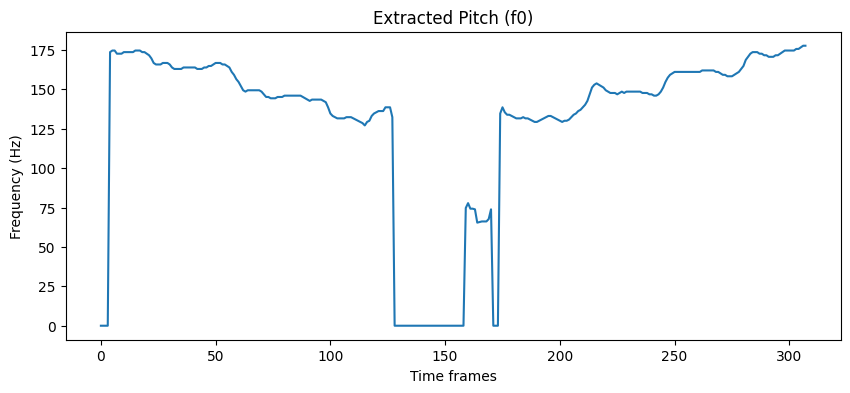

f0_tensor shape: torch.Size([308, 1])


In [4]:
import torch # 機械学習用ライブラリ

# 1. librosaを使ってピッチ抽出 (PYINアルゴリズム)
# f0: 時系列の周波数データ
# voiced_flag: 「声が出ているか(True)」「無音か(False)」のフラグ
f0_numpy, voiced_flag, voiced_probs = librosa.pyin(
    y,
    fmin=librosa.note_to_hz('C2'), # 最低音
    fmax=librosa.note_to_hz('C7'), # 最高音
    sr=sr,
    frame_length=1024
)

# 2. 扱いやすいように前処理
# 無音部分(NaN)を 0.0 に置き換える
f0_numpy = np.nan_to_num(f0_numpy)

# 3. PyTorchのTensorに変換 + 「形」を整える
# ここで例の unsqueeze(-1) が登場します！
# 時間軸方向にデータが並ぶように [T, 1] の形にします。
f0_tensor = torch.from_numpy(f0_numpy).float().unsqueeze(-1)

# グラフで見てみる
plt.figure(figsize=(10, 4))
plt.plot(f0_numpy)
plt.title("Extracted Pitch (f0)")
plt.xlabel("Time frames")
plt.ylabel("Frequency (Hz)")
plt.show()

print(f"f0_tensor shape: {f0_tensor.shape}")

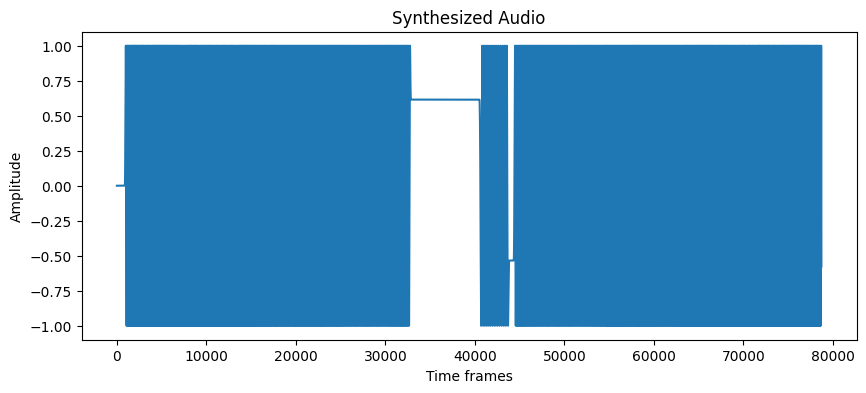

再合成された音声（サイン波だけど、あなたの歌い回しを再現）


In [13]:
def synthesize_ddsp(f0_curve, sr=16000):
    """
    f0_curve: [T, 1] の形をした、時間変化する周波数データ
    """

    # 1. 周波数を「位相の増分」に変換
    # 周波数 f とは「1秒間に f 回回転する」という意味
    # 1サンプルあたりに進む角度 = 2π * f / sr
    phase_increment = 2 * np.pi * f0_curve / sr

    # 2. 累積和（積分）をとって、現在の位相(角度)を求める
    # cumsum: [a, b, c] -> [a, a+b, a+b+c]
    phase = torch.cumsum(phase_increment, dim=0)

    # 3. サイン波にする
    # sin(積分した位相)
    audio = torch.sin(phase)

    plt.figure(figsize=(10, 4))
    plt.plot(audio.squeeze().numpy())
    plt.title("Synthesized Audio")
    plt.xlabel("Time frames")
    plt.ylabel("Amplitude")
    plt.show()

    return audio

# --- 実験 ---

# さっき抽出した f0_tensor を、元と同じ長さになるように引き伸ばす
# (librosaで抽出したf0はサンプル数が減っているため、元の長さに戻す補間処理)
target_length = len(y)
f0_interpolated = torch.nn.functional.interpolate(
    f0_tensor.unsqueeze(0).transpose(1, 2), # [1, 1, T] に変形して補間
    size=target_length,
    mode='linear'
).squeeze(0).transpose(0, 1) # [T, 1] に戻す

# 再合成！
synthesized_audio = synthesize_ddsp(f0_interpolated, sr=sr)

print("再合成された音声（サイン波だけど、あなたの歌い回しを再現）")
display(Audio(synthesized_audio.squeeze().numpy(), rate=sr))

In [8]:
# 概念コード（次の実験用）

voices = []
for i in range(3):
    # 1. あなたのf0に、AI（今はランダム）で揺らぎを加える
    noise = torch.randn_like(f0_interpolated) * 3.0 # 適当なノイズ
    f0_new = f0_interpolated + noise

    # 2. 合成
    voice = synthesize_ddsp(f0_new)
    voices.append(voice)

# 3. 全員混ぜる
unison = sum(voices) / 3

In [9]:
display(Audio(unison.squeeze().numpy(), rate=sr))

In [10]:
def synthesize_additive(f0_curve, n_harmonics=30, sr=16000):
    """
    時間変化するf0を受け取り、倍音を重ねてリッチな音にする
    """
    # 1. 基本周波数の位相（角度）を計算
    # (前回と同じ、速度を積分して距離を出す処理)
    phase_increment = 2 * np.pi * f0_curve / sr
    phase = torch.cumsum(phase_increment, dim=0)

    # 2. 音の器を用意
    audio = torch.zeros_like(phase)

    # 3. 倍音を重ねていく
    for k in range(1, n_harmonics + 1):
        # k倍の周波数 = 位相もk倍進む
        k_phase = phase * k

        # 音量: 高い音ほど小さく (1/k) -> ノコギリ波に近い、声っぽい音になる
        # ※本来はここをAIが制御して「あ」や「い」を作ります
        amp = 1.0 / k

        # 4. ランダムな位相ズレ（Phase Randomization）
        # これがないと、全ての倍音が完全に同期して機械的な音になります
        # 合唱ではこの「初期位相のズレ」が重要です
        random_phase_shift = torch.rand(1) * 2 * np.pi

        audio += amp * torch.sin(k_phase + random_phase_shift)

    # 正規化（音割れ防止）
    audio = audio / torch.max(torch.abs(audio))
    return audio

# --- 確認 ---
# さっきの f0_interpolated を使って、リッチな音で再生
print("倍音ありの音声（少しブザーっぽいですが、声に近づきました）")
rich_voice = synthesize_additive(f0_interpolated, n_harmonics=40)
display(Audio(rich_voice.squeeze().numpy(), rate=sr))

倍音ありの音声（少しブザーっぽいですが、声に近づきました）


In [11]:
def generate_ensemble_baseline(base_f0, n_voices=3, pitch_drift_amount=2.0, time_drift_ms=20):
    """
    ベースライン手法：ランダムなノイズで揺らぎを作る
    """
    voices = []

    print(f"--- {n_voices}人のユニゾンを生成中 ---")

    for i in range(n_voices):
        # ==========================================
        # ここが将来、AI（ニューラルネット）に置き換わる部分です
        # ==========================================

        # 1. ピッチの揺らぎ (Perlin Noise的になめらかにするのが理想ですが、今は簡易ランダム)
        # Low-pass filterをかけないとジリジリするので、簡易的に移動平均をとります
        raw_noise = torch.randn_like(base_f0) # 正規分布から乱数を生成
        smooth_noise = torch.nn.functional.avg_pool1d( #1d畳み込み（501サンプル（31ms程度）を行う。人間の声は数十ミリ秒かけてゆっくりと変化するため、高周波成分におけるノイズはキャンセル）
            raw_noise.unsqueeze(0).transpose(1, 2),
            kernel_size=501, stride=1, padding=250
        ).squeeze(0).transpose(0, 1)

        # ノイズの大きさを調整
        pitch_noise = smooth_noise * pitch_drift_amount

        # 新しいf0カーブ
        new_f0 = base_f0 + pitch_noise

        # 2. タイミングのズレ
        # 音声を時間軸方向に少しずらす（shift）
        # サンプル数 = ms * (sr / 1000)
        shift_samples = int((torch.rand(1) - 0.5) * 2 * time_drift_ms * (sr / 1000))

        # 3. 合成
        voice = synthesize_additive(new_f0, n_harmonics=40, sr=sr)

        # 時間ズレを適用（roll）
        voice = torch.roll(voice, shifts=shift_samples, dims=0)

        # リストに追加
        voices.append(voice)
        print(f"Voice {i+1}: 生成完了 (Pitch Shift max approx: {pitch_noise.abs().max():.2f}Hz)")

    # 4. ミックス（単純平均）
    # stack: [T, 1] の音声を3つ束ねて [3, T, 1] にする
    ensemble = torch.stack(voices, dim=0)

    # 平均をとって [T, 1] に戻す
    mixed_audio = torch.mean(ensemble, dim=0)

    return mixed_audio

# --- 実験: ユニゾン生成 ---
# pitch_drift_amount: 揺らぎの大きさ（Hz）。大きくすると音痴になります。
unison_audio = generate_ensemble_baseline(f0_interpolated, n_voices=5, pitch_drift_amount=3.5)

print("\n★ 完成した疑似ユニゾン（ベースライン） ★")
display(Audio(unison_audio.squeeze().numpy(), rate=sr))

--- 5人のユニゾンを生成中 ---
Voice 1: 生成完了 (Pitch Shift max approx: 0.54Hz)
Voice 2: 生成完了 (Pitch Shift max approx: 0.53Hz)
Voice 3: 生成完了 (Pitch Shift max approx: 0.56Hz)
Voice 4: 生成完了 (Pitch Shift max approx: 0.56Hz)
Voice 5: 生成完了 (Pitch Shift max approx: 0.80Hz)

★ 完成した疑似ユニゾン（ベースライン） ★
